In [1]:
import re
import nltk
import numpy as np
import pandas as pd
import seaborn as sns

from matplotlib import pyplot as plt
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer

nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\harsh\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [2]:
# Load contents, correlations and topics file
BASE_DIR = "data/"
content = pd.read_csv(BASE_DIR+"content.csv")
correlations = pd.read_csv(BASE_DIR+"correlations.csv")
topic = pd.read_csv(BASE_DIR+"topics.csv")

In [3]:
# Print the original size of the data
print("Original contents file shape:", content.shape)
print("Original topics file shape:", topic.shape)
print("Original correlations file shape:", correlations.shape)

Original contents file shape: (154047, 8)
Original topics file shape: (76972, 9)
Original correlations file shape: (61517, 2)


In [4]:
# Use only CONTENT whose language is english
english_filtered_content = content[content["language"]=="en"]
# Use only TOPICS whose language is english & has content & drop rows if there are any NAN present in the dataset
english_filtered_topics = topic[(topic["language"]=="en") & (topic["has_content"]==1)].dropna()

In [5]:
# Print the filtered size of the data
print("Filtered content shape:", english_filtered_content.shape)
print("Filtered topic shape:", english_filtered_topics.shape)
print("Filtered correlations shape:", correlations.shape)

Filtered content shape: (65939, 8)
Filtered topic shape: (9073, 9)
Filtered correlations shape: (61517, 2)


#### Filter based on content

In [6]:
# We want to focus on CONTENT which is available as a document or video or html5
english_filtered_content = english_filtered_content[(english_filtered_content["kind"]=="document")]
english_filtered_content = english_filtered_content.dropna()
print("Filtered content shape:", english_filtered_content.shape)

Filtered content shape: (6847, 8)


In [7]:
# First find the topics which are in correlations dataset and filtered english topic dataset
english_filtered_correlation = correlations[correlations['topic_id'].isin(english_filtered_topics['id'])]
# print(english_filtered_correlation.shape)
# Each topic has multiple contents inside it - so split the correlations dataset so that each topic is associated to a single content file
exploded_english_filtered_correlation = english_filtered_correlation.assign(content_ids=english_filtered_correlation['content_ids'].str.split()).explode('content_ids')
# print(english_filtered_correlation.shape)
# Find the contents which are in correlations dataset and filtered english content dataset
exploded_english_filtered_correlation = exploded_english_filtered_correlation[exploded_english_filtered_correlation['content_ids'].isin(english_filtered_content['id'])]
# print(english_filtered_correlation.shape)
# Count the number of content available for each topic
new_english_filtered_correlation = exploded_english_filtered_correlation["topic_id"].value_counts().to_frame('counts').reset_index()
# english_filtered_correlation_count

In [89]:
# Get topics that have the highest amount of content available
top_topics = new_english_filtered_correlation.iloc[0:3]
print(top_topics)
first_topic, second_topic = top_topics.iloc[0,0], top_topics.iloc[1,0]

            index  counts
0  t_58ca0afc0bae     270
1  t_17bf2af6d82b     214
2  t_ba5de272b4cb     205


In [90]:
first_topic_content = english_filtered_correlation[english_filtered_correlation['topic_id']==first_topic]["content_ids"]
second_topic_content = english_filtered_correlation[english_filtered_correlation['topic_id']==second_topic]["content_ids"]
# third_topic_content = english_filtered_correlation[english_filtered_correlation['topic_id']==third_topic]["content_ids"]

In [91]:
first_list = first_topic_content.str.split().tolist()
second_list = second_topic_content.str.split().tolist()
# third_list = third_topic_content.str.split().tolist()
final_list = first_list[0] + second_list[0] #+ third_list[0]
len(final_list)

484

In [92]:
zeros = np.zeros((len(first_list[0]),1), dtype=int)
ones = np.ones((len(second_list[0]),1), dtype=int)
# twos = 2*np.ones((len(third_list[0]),1), dtype=int)

result_array = np.concatenate((zeros, ones))
result_array.shape

(484, 1)

In [93]:
curriculum_dataframe = pd.DataFrame({"content_ids" : final_list, "true_values" : result_array.tolist()})
curriculum_dataframe

,content_ids,true_values
0,c_0286ded417a2,[0]
1,c_02a5e75e01f0,[0]
2,c_02adc62b7731,[0]
3,c_04213823e40c,[0]
4,c_044e55056282,[0]
...,...,...
479,c_faaa92210fe1,[1]
480,c_faaea6c6ad4c,[1]
481,c_fae0b7c7a87a,[1]
482,c_fd75a88c2bb4,[1]


In [94]:
new_curriculum_dataframe = pd.merge(curriculum_dataframe,english_filtered_content,left_on="content_ids", right_on="id").drop(["id", "language", "kind", "license", "copyright_holder"],axis=1)
new_curriculum_dataframe

,content_ids,true_values,title,description,text
0,c_0286ded417a2,[0],Chapter 142: RenderScript,Chapter 142 of the book on Android.,Chapter 142: RenderScript\nRenderScript is a s...
1,c_02a5e75e01f0,[0],Chapter 161: TransitionDrawable,Chapter 161 of the book on Android.,Chapter 161: TransitionDrawable\nSection 161.1...
2,c_02adc62b7731,[0],Chapter 31: Supporting Screens With Dierent R...,Chapter 31 of the book on Android.,Chapter 31: Supporting Screens With\nDierent ...
3,c_04213823e40c,[0],Chapter 93: RoboGuice,Chapter 93 of the book on Android.,Chapter 93: RoboGuice\nSection 93.1: Simple ex...
4,c_044e55056282,[0],Chapter 219: Gson,Chapter 219 of the book on Android.,Chapter 219: Gson\nGson is a Java library that...
...,...,...,...,...,...
479,c_faaa92210fe1,[1],Chapter 148: GameCenter Leaderboards,Chapter 148 of the book on iOS Developer.,Chapter 148: GameCenter Leaderboards\nSection ...
480,c_faaea6c6ad4c,[1],Content list,"Section ""Content list"" of the book on iOS Deve...",iOS\nDeveloper\niOS Developer\nNotes for Profe...
481,c_fae0b7c7a87a,[1],Chapter 42: UIActivityViewController,Chapter 42 of the book on iOS Developer.,Chapter 42: UIActivityViewController\nParamete...
482,c_fd75a88c2bb4,[1],Chapter 25: UITextField Delegate,Chapter 25 of the book on iOS Developer.,Chapter 25: UITextField Delegate\nSection 25.1...


In [95]:
def remove_stopwords(text):
    '''
    Checks language of text then removes stopwords from that language if supported.
    '''
    lang_code = text[0:2]
    for word in stopwords.words("english"):
        text = text.replace(' ' + word + ' ', ' ')
    return text

In [96]:
#### Apply remove_stopwords() to our data
new_curriculum_dataframe["new_title"] = new_curriculum_dataframe.title.apply(remove_stopwords)
new_curriculum_dataframe["new_text"] = new_curriculum_dataframe.text.apply(remove_stopwords)
new_curriculum_dataframe["new_description"] = new_curriculum_dataframe.description.apply(remove_stopwords)

In [97]:
new_curriculum_dataframe.head()

,content_ids,true_values,title,description,text,new_title,new_text,new_description
0,c_0286ded417a2,[0],Chapter 142: RenderScript,Chapter 142 of the book on Android.,Chapter 142: RenderScript\nRenderScript is a s...,Chapter 142: RenderScript,Chapter 142: RenderScript\nRenderScript script...,Chapter 142 book Android.
1,c_02a5e75e01f0,[0],Chapter 161: TransitionDrawable,Chapter 161 of the book on Android.,Chapter 161: TransitionDrawable\nSection 161.1...,Chapter 161: TransitionDrawable,Chapter 161: TransitionDrawable\nSection 161.1...,Chapter 161 book Android.
2,c_02adc62b7731,[0],Chapter 31: Supporting Screens With Dierent R...,Chapter 31 of the book on Android.,Chapter 31: Supporting Screens With\nDierent ...,Chapter 31: Supporting Screens With Dierent R...,Chapter 31: Supporting Screens With\nDierent ...,Chapter 31 book Android.
3,c_04213823e40c,[0],Chapter 93: RoboGuice,Chapter 93 of the book on Android.,Chapter 93: RoboGuice\nSection 93.1: Simple ex...,Chapter 93: RoboGuice,Chapter 93: RoboGuice\nSection 93.1: Simple ex...,Chapter 93 book Android.
4,c_044e55056282,[0],Chapter 219: Gson,Chapter 219 of the book on Android.,Chapter 219: Gson\nGson is a Java library that...,Chapter 219: Gson,Chapter 219: Gson\nGson Java library used conv...,Chapter 219 book Android.


In [98]:
def preprocess_text(text: str) -> str:
    """This utility function sanitizes a string by:
    - removing links
    - removing special characters
    - removing numbers
    - removing stopwords
    - transforming in lowercase
    - removing excessive whitespaces
    Args:
        text (str): the input text you want to clean
        remove_stopwords (bool): whether or not to remove stopwords
    Returns:
        str: the cleaned text
    """

    # remove links
    text = re.sub(r"http\S+", "", text)
    # remove special chars and numbers
    text = re.sub("[^A-Za-z]+", " ", text)
    # remove
    text = re.sub(":"," ", text)
    #
    text = re.sub("\n"," ", text)
    # return text in lower case and stripped of whitespaces
    text = text.lower().strip()
    return text

In [99]:
new_curriculum_dataframe['text'] = new_curriculum_dataframe['new_text'].apply(lambda x: preprocess_text(x))
new_curriculum_dataframe['title'] = new_curriculum_dataframe['new_title'].apply(lambda x: preprocess_text(x))
new_curriculum_dataframe['description'] = new_curriculum_dataframe['new_description'].apply(lambda x: preprocess_text(x))

In [100]:
new_curriculum_dataframe.head()

,content_ids,true_values,title,description,text,new_title,new_text,new_description
0,c_0286ded417a2,[0],chapter renderscript,chapter book android,chapter renderscript renderscript scripting la...,Chapter 142: RenderScript,Chapter 142: RenderScript\nRenderScript script...,Chapter 142 book Android.
1,c_02a5e75e01f0,[0],chapter transitiondrawable,chapter book android,chapter transitiondrawable section animate vie...,Chapter 161: TransitionDrawable,Chapter 161: TransitionDrawable\nSection 161.1...,Chapter 161 book Android.
2,c_02adc62b7731,[0],chapter supporting screens with di erent resol...,chapter book android,chapter supporting screens with di erent resol...,Chapter 31: Supporting Screens With Dierent R...,Chapter 31: Supporting Screens With\nDierent ...,Chapter 31 book Android.
3,c_04213823e40c,[0],chapter roboguice,chapter book android,chapter roboguice section simple example robog...,Chapter 93: RoboGuice,Chapter 93: RoboGuice\nSection 93.1: Simple ex...,Chapter 93 book Android.
4,c_044e55056282,[0],chapter gson,chapter book android,chapter gson gson java library used convert ja...,Chapter 219: Gson,Chapter 219: Gson\nGson Java library used conv...,Chapter 219 book Android.


In [101]:
new_curriculum_dataframe["corpus"] = new_curriculum_dataframe["title"] + " " + new_curriculum_dataframe["description"] + " " + new_curriculum_dataframe["text"] 
new_curriculum_dataframe["corpus"] = new_curriculum_dataframe["corpus"].str.replace("chapter","")

In [102]:
# initialize the vectorizer
vectorizer = TfidfVectorizer(sublinear_tf=True, min_df=10, max_df=0.95)
# fit_transform applies TF-IDF to clean texts - we save the array of vectors in X
X = vectorizer.fit_transform(new_curriculum_dataframe["text"])

In [103]:
from sklearn.cluster import KMeans

# initialize kmeans with 3 centroids
kmeans = KMeans(n_clusters=2, random_state=42)
# fit the model
kmeans.fit(X)
# store cluster labels in a variable
clusters = kmeans.labels_

In [104]:
from sklearn.decomposition import PCA

# initialize PCA with 2 components
pca = PCA(n_components=2, random_state=42)
# pass our X to the pca and store the reduced vectors into pca_vecs
pca_vecs = pca.fit_transform(X.toarray())
# save our two dimensions into x0 and x1
x0 = pca_vecs[:, 0]
x1 = pca_vecs[:, 1]

In [105]:
pca_vecs

array([[-0.11725818, -0.00691977],
       [-0.24652415,  0.33441608],
       [-0.11347617,  0.14986506],
       [-0.22578294,  0.06560633],
       [-0.1388641 , -0.12946408],
       [-0.01939022, -0.0695589 ],
       [-0.28040495, -0.0647224 ],
       [-0.15197244, -0.19387106],
       [-0.26505211, -0.02576444],
       [-0.03763494, -0.09888873],
       [-0.00657601, -0.14813656],
       [-0.19116991, -0.14045459],
       [-0.17548261, -0.14928835],
       [-0.05424129, -0.13372139],
       [-0.04170713, -0.15117254],
       [-0.1313147 ,  0.07050938],
       [-0.26238349,  0.23956749],
       [-0.14852425, -0.06104232],
       [-0.09136398, -0.14582376],
       [-0.08051298, -0.08364988],
       [-0.23473923, -0.10696113],
       [-0.19223984, -0.11624669],
       [-0.24942235, -0.05258442],
       [-0.29731952,  0.24247525],
       [-0.09201808, -0.08476598],
       [-0.08670574, -0.09965369],
       [-0.03086132, -0.12351925],
       [-0.28080421, -0.03437428],
       [-0.24802179,

In [106]:
# assign clusters and pca vectors to our dataframe 
new_curriculum_dataframe['cluster'] = clusters
new_curriculum_dataframe['x0'] = x0
new_curriculum_dataframe['x1'] = x1

In [107]:
def get_top_keywords(n_terms):
    """This function returns the keywords for each centroid of the KMeans"""
    df = pd.DataFrame(X.todense()).groupby(clusters).mean() # groups the TF-IDF vector by cluster
    terms = vectorizer.get_feature_names_out() # access tf-idf terms
    for i,r in df.iterrows():
        print('\nCluster {}'.format(i))
        print(','.join([terms[t] for t in np.argsort(r)[-n_terms:]])) # for each row of the dataframe, find the n terms that have the highest tf idf score
            
get_top_keywords(10)


Cluster 0
id,this,layout,override,void,string,int,new,public,android

Cluster 1
the,view,nil,objective,func,swift,self,let,developer,ios


In [108]:
# map clusters to appropriate labels 
cluster_map = {0: "Topic 1", 1: "Topic 2", 2: "Topic 3"}
# apply mapping
new_curriculum_dataframe['cluster'] = new_curriculum_dataframe['cluster'].map(cluster_map)

In [121]:
new_curriculum_dataframe

,content_ids,true_values,title,description,text,new_title,new_text,new_description,corpus,cluster,x0,x1
0,c_0286ded417a2,[0],chapter renderscript,chapter book android,chapter renderscript renderscript scripting la...,Chapter 142: RenderScript,Chapter 142: RenderScript\nRenderScript script...,Chapter 142 book Android.,renderscript book android renderscript rend...,Topic 1,-0.117258,-0.006920
1,c_02a5e75e01f0,[0],chapter transitiondrawable,chapter book android,chapter transitiondrawable section animate vie...,Chapter 161: TransitionDrawable,Chapter 161: TransitionDrawable\nSection 161.1...,Chapter 161 book Android.,transitiondrawable book android transitiond...,Topic 1,-0.246524,0.334416
2,c_02adc62b7731,[0],chapter supporting screens with di erent resol...,chapter book android,chapter supporting screens with di erent resol...,Chapter 31: Supporting Screens With Dierent R...,Chapter 31: Supporting Screens With\nDierent ...,Chapter 31 book Android.,supporting screens with di erent resolutions ...,Topic 1,-0.113476,0.149865
3,c_04213823e40c,[0],chapter roboguice,chapter book android,chapter roboguice section simple example robog...,Chapter 93: RoboGuice,Chapter 93: RoboGuice\nSection 93.1: Simple ex...,Chapter 93 book Android.,roboguice book android roboguice section si...,Topic 1,-0.225783,0.065606
4,c_044e55056282,[0],chapter gson,chapter book android,chapter gson gson java library used convert ja...,Chapter 219: Gson,Chapter 219: Gson\nGson Java library used conv...,Chapter 219 book Android.,gson book android gson gson java library us...,Topic 1,-0.138864,-0.129464
...,...,...,...,...,...,...,...,...,...,...,...,...
479,c_faaa92210fe1,[1],chapter gamecenter leaderboards,chapter book ios developer,chapter gamecenter leaderboards section gamece...,Chapter 148: GameCenter Leaderboards,Chapter 148: GameCenter Leaderboards\nSection ...,Chapter 148 book iOS Developer.,gamecenter leaderboards book ios developer ...,Topic 2,0.205980,-0.043670
480,c_faaea6c6ad4c,[1],content list,section content list book ios developer,ios developer ios developer notes professional...,Content list,iOS\nDeveloper\niOS Developer\nNotes Professio...,"Section ""Content list"" book iOS Developer.",content list section content list book ios dev...,Topic 2,0.153380,0.107826
481,c_fae0b7c7a87a,[1],chapter uiactivityviewcontroller,chapter book ios developer,chapter uiactivityviewcontroller parameter nam...,Chapter 42: UIActivityViewController,Chapter 42: UIActivityViewController\nParamete...,Chapter 42 book iOS Developer.,uiactivityviewcontroller book ios developer ...,Topic 2,0.277720,-0.043786
482,c_fd75a88c2bb4,[1],chapter uitextfield delegate,chapter book ios developer,chapter uitextfield delegate section actions u...,Chapter 25: UITextField Delegate,Chapter 25: UITextField Delegate\nSection 25.1...,Chapter 25 book iOS Developer.,uitextfield delegate book ios developer uit...,Topic 2,0.185265,-0.039178


### Plotting

In [137]:
count_one = 0
count_two = 0
for i in range(484):
    # print(i)
    if (new_curriculum_dataframe.loc[i, "true_values"] == [0]) and (new_curriculum_dataframe.loc[i, "cluster"] == "Topic 1"):
        count_one += 1
    if (new_curriculum_dataframe.loc[i, "true_values"] == [1]) and (new_curriculum_dataframe.loc[i, "cluster"] == "Topic 2"):
        count_two += 1

print(count_one)
print(count_two)

265
214


In [133]:
type(new_curriculum_dataframe.loc[0, "true_values"])

list

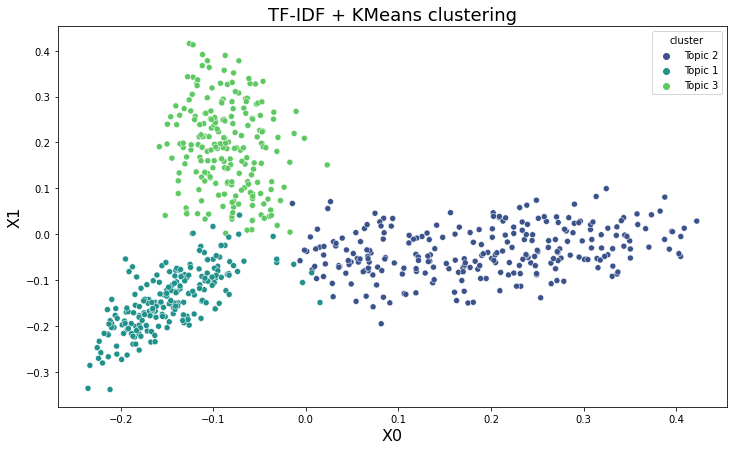

In [88]:
# set image size
plt.figure(figsize=(12, 7))
# set a title
plt.title("TF-IDF + KMeans clustering", fontdict={"fontsize": 18})
# set axes names
plt.xlabel("X0", fontdict={"fontsize": 16})
plt.ylabel("X1", fontdict={"fontsize": 16})
# create scatter plot with seaborn, where hue is the class used to group the data
sns.scatterplot(data=new_curriculum_dataframe, x='x0', y='x1', hue='cluster', palette="viridis")
plt.show()